In [1]:
%load_ext autotime

import scarf
scarf.__version__

'0.19.6'

In [2]:
scarf.fetch_dataset(
    'tenx_5K_pbmc_rnaseq',
    save_path='scarf_datasets'
)

#### convert into Zarr format

In [3]:
reader = scarf.CrH5Reader(
    'scarf_datasets/tenx_5K_pbmc_rnaseq/data.h5'
    )

In [4]:
reader.nCells, reader.nFeatures

(5025, 33538)

In [5]:
writer = scarf.CrToZarr(
    reader,
    zarr_fn='scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr',
    chunk_size=(2000, 1000)
)
writer.dump(batch_size=1000)

  0%|                                                                                                         …

In [6]:
ds = scarf.DataStore(
    'scarf_datasets/tenx_5K_pbmc_rnaseq/data.zarr',
    nthreads=4,
    min_features_per_cell=10
)

(RNA) Computing nCells and dropOuts:   0%|                                                                    …

(RNA) Computing nCounts:   0%|                                                                                …

(RNA) Computing nFeatures:   0%|                                                                              …

(RNA) Computing RNA_percentMito:   0%|                                                                        …

(RNA) Computing RNA_percentRibo:   0%|                                                                        …

#### Cell filtering

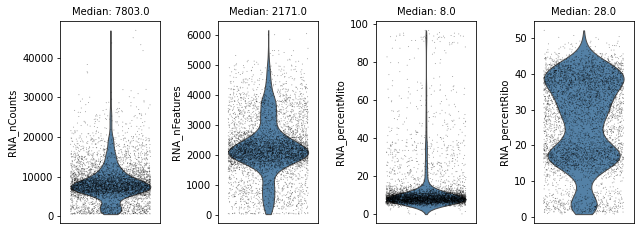

In [7]:
ds.plot_cells_dists()

In [8]:
ds.filter_cells(
    attrs=['RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito'],
    highs=[15000, 4000, 15],
    lows=[1000, 500, 0]
)

INFO: 597 cells flagged for filtering out using attribute RNA_nCounts
INFO: 461 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 612 cells flagged for filtering out using attribute RNA_percentMito


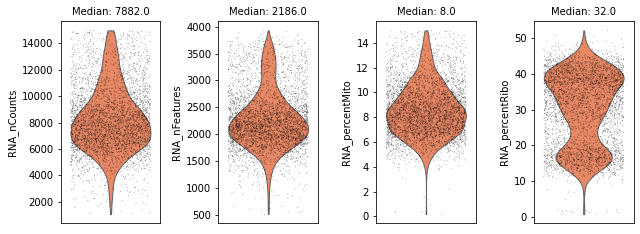

In [9]:
ds.plot_cells_dists(cell_key='I', color='coral')

In [10]:
ds.cells.head()

,I,ids,names,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo
0,True,AAACCCAAGCGTATGG-1,AAACCCAAGCGTATGG-1,13537.0,3503.0,10.844353,16.783630
1,True,AAACCCAGTCCTACAA-1,AAACCCAGTCCTACAA-1,12668.0,3381.0,5.975687,20.034733
2,False,AAACCCATCACCTCAC-1,AAACCCATCACCTCAC-1,962.0,346.0,53.430353,2.494802
3,True,AAACGCTAGGGCATGT-1,AAACGCTAGGGCATGT-1,5788.0,1799.0,10.919143,28.783690
4,True,AAACGCTGTAGGTACG-1,AAACGCTGTAGGTACG-1,13186.0,2887.0,7.955407,35.750038


#### Feature selection

In [11]:
ds.RNA.feats.head()

,I,ids,names,dropOuts,nCells
0,False,ENSG00000243485,MIR1302-2HG,5025,0
1,False,ENSG00000237613,FAM138A,5025,0
2,False,ENSG00000186092,OR4F5,5025,0
3,True,ENSG00000238009,AL627309.1,4976,49
4,False,ENSG00000239945,AL627309.3,5022,3


In [12]:
ds.RNA.sf

1000

(RNA) Computing nCells:   0%|                                                                                 …

(RNA) Computing normed_tot:   0%|                                                                             …

(RNA) Computing sigmas:   0%|                                                                                 …

INFO: 497 genes marked as HVGs


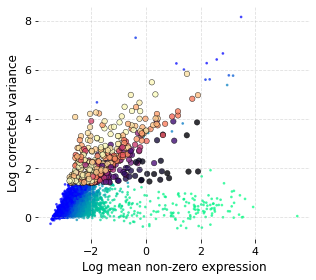

In [13]:
ds.mark_hvgs(
    min_cells=20,
    top_n=500,
    min_mean=-3,
    max_mean=2,
    max_var=6
)

In [14]:
ds.RNA.feats.head()

,I,ids,names,I__hvgs,dropOuts,nCells,stats_I_avg,stats_I_c_var__200__0.1,stats_I_normed_n,stats_I_normed_tot,stats_I_nz_mean,stats_I_sigmas
0,False,ENSG00000243485,MIR1302-2HG,False,5025,0,NaN,NaN,NaN,NaN,NaN,NaN
1,False,ENSG00000237613,FAM138A,False,5025,0,NaN,NaN,NaN,NaN,NaN,NaN
2,False,ENSG00000186092,OR4F5,False,5025,0,NaN,NaN,NaN,NaN,NaN,NaN
3,True,ENSG00000238009,AL627309.1,False,4976,49,0.000914,1.555434,33.0,4.593283,0.13919,0.000196
4,False,ENSG00000239945,AL627309.3,False,5022,3,NaN,NaN,NaN,NaN,NaN,NaN


#### Graph creation

In [15]:
ds.make_graph(
    feat_key='hvgs',
    k=11,
    dims=15,
    n_centroids=100
)

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__hvgs/data:   0%|                                                                   …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.95%


#### Low dimensional embedding and clustering

In [16]:
ds.run_umap(
    n_epochs=250,
    spread=5,
    min_dist=1,
    parallel=True
)

Training UMAP:   0%|                                                                                          …

In [17]:
ds.cells.head()

,I,ids,names,RNA_UMAP1,RNA_UMAP2,RNA_nCounts,RNA_nFeatures,RNA_percentMito,RNA_percentRibo
0,True,AAACCCAAGCGTATGG-1,AAACCCAAGCGTATGG-1,15.777423,13.045919,13537.0,3503.0,10.844353,16.783630
1,True,AAACCCAGTCCTACAA-1,AAACCCAGTCCTACAA-1,32.385704,16.662020,12668.0,3381.0,5.975687,20.034733
2,False,AAACCCATCACCTCAC-1,AAACCCATCACCTCAC-1,NaN,NaN,962.0,346.0,53.430353,2.494802
3,True,AAACGCTAGGGCATGT-1,AAACGCTAGGGCATGT-1,23.213589,-26.655598,5788.0,1799.0,10.919143,28.783690
4,True,AAACGCTGTAGGTACG-1,AAACGCTGTAGGTACG-1,6.384401,-17.078487,13186.0,2887.0,7.955407,35.750038


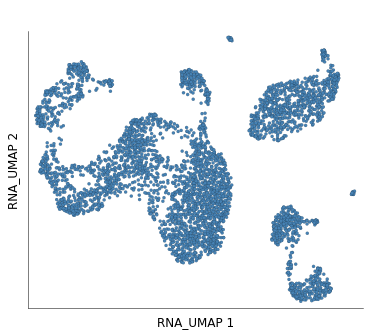

In [18]:
ds.plot_layout(layout_key='RNA_UMAP')